# 💻 Code for figures

[Download the notebook](https://github.com/neuro4ml/neuro4ml.github.io/blob/main/Week_1/code-for-figures.ipynb)
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuro4ml/neuro4ml.github.io/blob/main/Week_1/code-for-figures.ipynb)

The code below generates the figures used in the notebooks, and might be useful to explore these ideas further. 

## Neuron models

It makes use of the [Brian spiking neural network simulator package](https://briansimulator.org/). Feel free to have a play with this and explore its [documentation](https://brian2.readthedocs.io/en/stable/), including excellent tutorials.

In [1]:
!pip install brian2
import os
from brian2 import *
prefs.codegen.target = 'numpy'

C:\Users\dgoodman\AppData\Roaming\Python\Python39\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## "Biological" neurons

This is just a Hodgkin-Huxley neuron modified to include exponential current synapses (as we do later for the integrate-and-fire neuron).

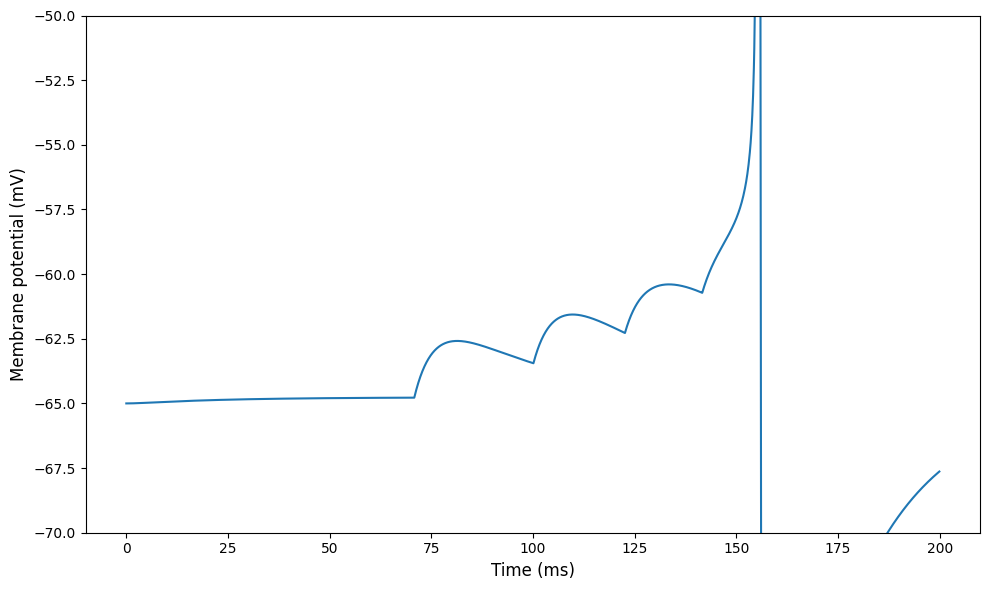

In [10]:
start_scope()

duration = 200*ms

# Parameters
area = 20000*umetre**2
Cm = (1*ufarad*cm**-2) * area
gl = (5e-5*siemens*cm**-2) * area

El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = (100*msiemens*cm**-2) * area
g_kd = (30*msiemens*cm**-2) * area
VT = -63*mV
# Time constants
taue = 5*ms
taui = 10*ms
# Reversal potentials
Ee = 0*mV
Ei = -80*mV
we = 2*nS  # excitatory synaptic weight
wi = 67*nS  # inhibitory synaptic weight

# The model
eqs = Equations('''
dv/dt = (gl*(El-v)+ge*(Ee-v)+gi*(Ei-v)-
         g_na*(m*m*m)*h*(v-ENa)-
         g_kd*(n*n*n*n)*(v-EK))/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dge/dt = -ge*(1./taue) : siemens
dgi/dt = -gi*(1./taui) : siemens
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-v+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((v-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-v+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-v+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-v+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-v+VT)/(40*mV))/ms : Hz
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(1, eqs, threshold='v>-20*mV', refractory=3*ms,
                method='exponential_euler')
group.v = El

# Little trick to get a sequence of input spikes that get faster and faster
inp_sp = NeuronGroup(1, 'dv/dt=int(t<150*ms)*t/(50*ms)**2:1', threshold='v>1', reset='v=0', method='euler')
S = Synapses(inp_sp, group, on_pre='ge += we')
S.connect(p=1)

monitor = StateMonitor(group, 'v', record=True)
input_monitor = SpikeMonitor(inp_sp)

run(duration)

figure(figsize=(10,6))
plot(monitor.t/ms, monitor.v[0]/mV)
ylim(-70, -50)
ylabel('Membrane potential (mV)', fontsize=12)
xlabel('Time (ms)', fontsize=12)
tight_layout()

### Version for website

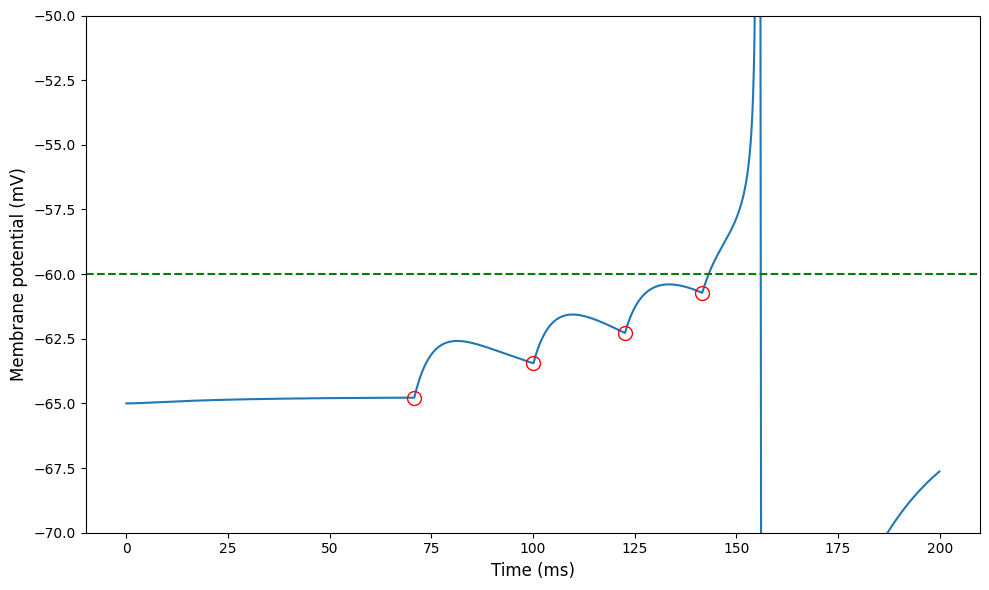

In [11]:
#| label: bioneuron

figure(figsize=(10,6))
plot(monitor.t/ms, monitor.v[0]/mV)
plot(input_monitor.t/ms, monitor.v[0][array(input_monitor.t/inp_sp.dt, dtype=int)]/mV, 'o', color='r', mfc='none', ms=10)
axhline(-60, ls='--', color='g')

ylim(-70, -50)
ylabel('Membrane potential (mV)', fontsize=12)
xlabel('Time (ms)', fontsize=12)
tight_layout();


## Integrate and fire neuron

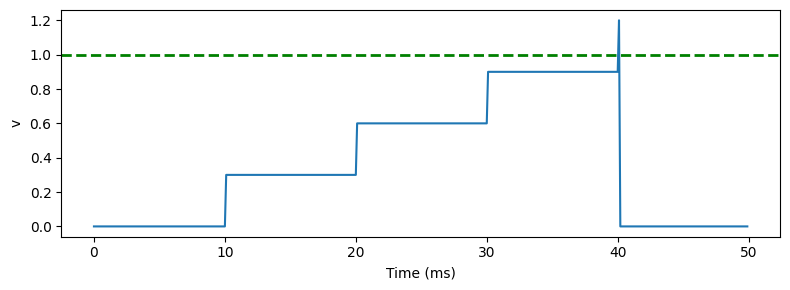

In [12]:
#| label: integrate-and-fire-fig-label

start_scope()

duration = 50*ms

eqs = '''
dv/dt = 0/second : 1
'''
G_out = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
nspikes_in = 100
timesep_in = 10*ms
G_in = SpikeGeneratorGroup(1, [0]*nspikes_in, (1+arange(nspikes_in))*timesep_in)
S = Synapses(G_in, G_out, on_pre='v += 0.3')
S.connect(p=1)
M = StateMonitor(G_out, 'v', record=True)
run(duration)
figure(figsize=(8, 3))
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')
axhline(1, ls='--', c='g', lw=2)
tight_layout()

## Leaky integrate and fire neuron

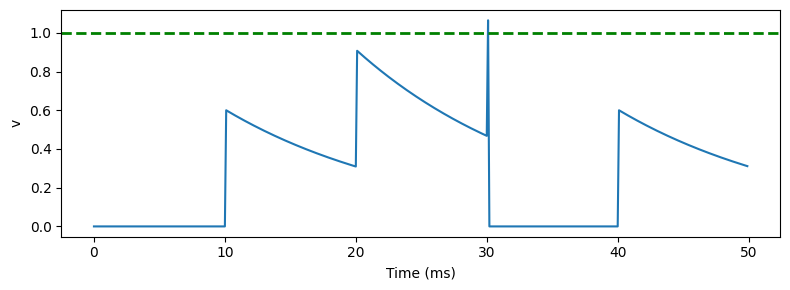

In [13]:
#| label: LIF-fig-label

start_scope()

duration = 50*ms

eqs = '''
dv/dt = -v/(15*ms) : 1
'''
G_out = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
nspikes_in = 100
timesep_in = 10*ms
G_in = SpikeGeneratorGroup(1, [0]*nspikes_in, (1+arange(nspikes_in))*timesep_in)
S = Synapses(G_in, G_out, on_pre='v += 0.6')
S.connect(p=1)
M = StateMonitor(G_out, 'v', record=True)
run(duration)
figure(figsize=(8, 3))
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')
axhline(1, ls='--', c='g', lw=2)
tight_layout()

## Reliable spike timing

This is the figure we want to reproduce from [Mainen and Sejnowski (1995)](https://pubmed.ncbi.nlm.nih.gov/7770778/).

![](figures/mainen-reliable.png)

And here's some Brian code that does the same thing with a leaky integrate and fire neuron.

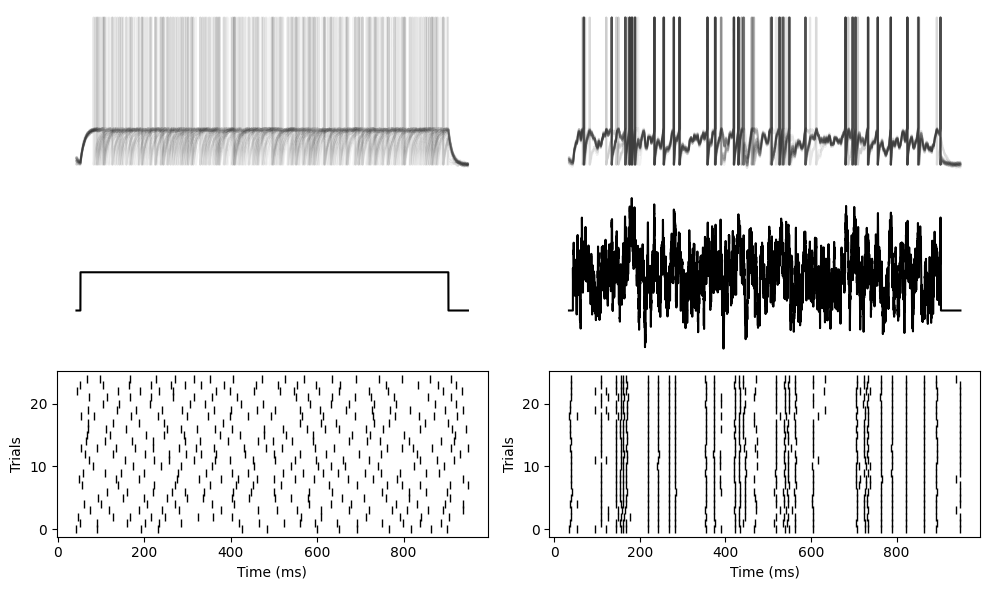

In [14]:
#| label: Brian-LIF-fig-label

figure(figsize=(10, 6))

# Neuron equations and parameters
tau = 10*ms
sigma = .03
eqs_neurons = '''
dx/dt = (.65*I - x) / tau + sigma * (2 / tau)**.5 * xi : 1
I = I_shared*int((t>10*ms) and (t<950*ms)) : 1
I_shared : 1 (linked)
'''

start_scope()

# The common input
N = 25
neuron_input = NeuronGroup(1, 'x = 1.5 : 1', method='euler')

# The noisy neurons receiving the same input
neurons = NeuronGroup(N, model=eqs_neurons, threshold='x > 1',
                      reset='x = 0', refractory=5*ms, method='euler')
neurons.x = 'rand()*0.2'
neurons.I_shared = linked_var(neuron_input, 'x') # input.x is continuously fed into neurons.I
spikes = SpikeMonitor(neurons)
M = StateMonitor(neurons, ('x', 'I'), record=True)

run(1000*ms)

def add_spike_peak(x, t, i):
    T = array(rint(t/defaultclock.dt), dtype=int)
    y = x.copy()
    y[T, i] = 4
    return y

ax_top = subplot(321)
plot(M.t/ms, add_spike_peak(M.x[:].T, spikes.t[:], spikes.i[:]), '-k', alpha=0.05)
ax_top.set_frame_on(False)
xticks([])
yticks([])
ax_mid = subplot(323)
plot(M.t/ms, M.I[0], '-k')
ax_mid.set_frame_on(False)
xticks([])
yticks([])
subplot(325)
plot(spikes.t/ms, spikes.i, '|k')
xlabel('Time (ms)')
ylabel('Trials')

start_scope()

# The common noisy input
N = 25
tau_input = 3*ms
neuron_input = NeuronGroup(1, 'dx/dt = (1.5-x) / tau_input + (2 /tau_input)**.5 * xi : 1', method='euler')

# The noisy neurons receiving the same input
neurons = NeuronGroup(N, model=eqs_neurons, threshold='x > 1',
                      reset='x = 0', refractory=5*ms, method='euler')
neurons.x = 'rand()*0.2'
neurons.I_shared = linked_var(neuron_input, 'x') # input.x is continuously fed into neurons.I
spikes = SpikeMonitor(neurons)
M = StateMonitor(neurons, ('x', 'I'), record=True)

run(1000*ms)

ax = subplot(322, sharey=ax_top)
plot(M.t/ms, add_spike_peak(M.x[:].T, spikes.t[:], spikes.i[:]), '-k', alpha=0.05)
ax.set_frame_on(False)
xticks([])
yticks([])
ax = subplot(324, sharey=ax_mid)
plot(M.t/ms, M.I[0], '-k')
ax.set_frame_on(False)
xticks([])
yticks([])
subplot(326)
plot(spikes.t/ms, spikes.i, '|k')
xlabel('Time (ms)')
ylabel('Trials')

tight_layout()

And same with a non-leaky integrate-and-fire neuron.

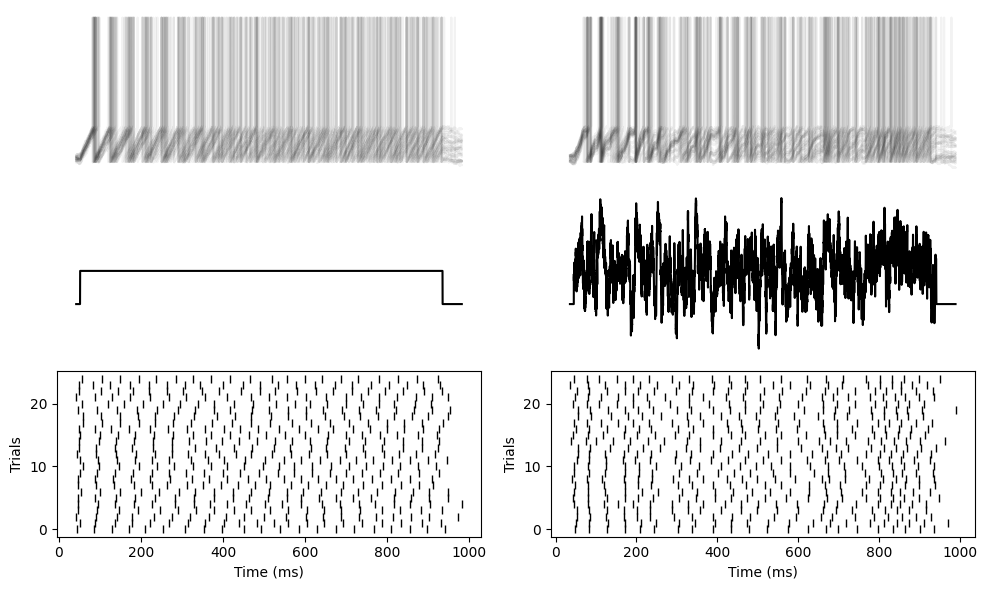

In [15]:
#| label: Brian-non-LIF-fig-label

figure(figsize=(10, 6))

# Neuron equations and parameters
tau = 10*ms
sigma = .03
eqs_neurons = '''
dx/dt = (.15*I) / tau + sigma * (2 / tau)**.5 * xi : 1
I = I_shared*int((t>10*ms) and (t<950*ms)) : 1
I_shared : 1 (linked)
'''

start_scope()

# The common input
N = 25
neuron_input = NeuronGroup(1, 'x = 1.5 : 1', method='euler')

# The noisy neurons receiving the same input
neurons = NeuronGroup(N, model=eqs_neurons, threshold='x > 1',
                      reset='x = 0', refractory=5*ms, method='euler')
neurons.x = 'rand()*0.2'
neurons.I_shared = linked_var(neuron_input, 'x') # input.x is continuously fed into neurons.I
spikes = SpikeMonitor(neurons)
M = StateMonitor(neurons, ('x', 'I'), record=True)

run(1000*ms)

def add_spike_peak(x, t, i):
    T = array(rint(t/defaultclock.dt), dtype=int)
    y = x.copy()
    y[T, i] = 4
    return y

ax_top = subplot(321)
plot(M.t/ms, add_spike_peak(M.x[:].T, spikes.t[:], spikes.i[:]), '-k', alpha=0.05)
ax_top.set_frame_on(False)
xticks([])
yticks([])
ax_mid = subplot(323)
plot(M.t/ms, M.I[0], '-k')
ax_mid.set_frame_on(False)
xticks([])
yticks([])
subplot(325)
plot(spikes.t/ms, spikes.i, '|k')
xlabel('Time (ms)')
ylabel('Trials')

start_scope()

# The common noisy input
N = 25
tau_input = 3*ms
neuron_input = NeuronGroup(1, 'dx/dt = (1.5-x) / tau_input + (2 /tau_input)**.5 * xi : 1', method='euler')

# The noisy neurons receiving the same input
neurons = NeuronGroup(N, model=eqs_neurons, threshold='x > 1',
                      reset='x = 0', refractory=5*ms, method='euler')
neurons.x = 'rand()*0.2'
neurons.I_shared = linked_var(neuron_input, 'x') # input.x is continuously fed into neurons.I
spikes = SpikeMonitor(neurons)
M = StateMonitor(neurons, ('x', 'I'), record=True)

run(1000*ms)

ax = subplot(322, sharey=ax_top)
plot(M.t/ms, add_spike_peak(M.x[:].T, spikes.t[:], spikes.i[:]), '-k', alpha=0.05)
ax.set_frame_on(False)
xticks([])
yticks([])
ax = subplot(324, sharey=ax_mid)
plot(M.t/ms, M.I[0], '-k')
ax.set_frame_on(False)
xticks([])
yticks([])
subplot(326)
plot(spikes.t/ms, spikes.i, '|k')
xlabel('Time (ms)')
ylabel('Trials')

tight_layout()

## LIF with synapses

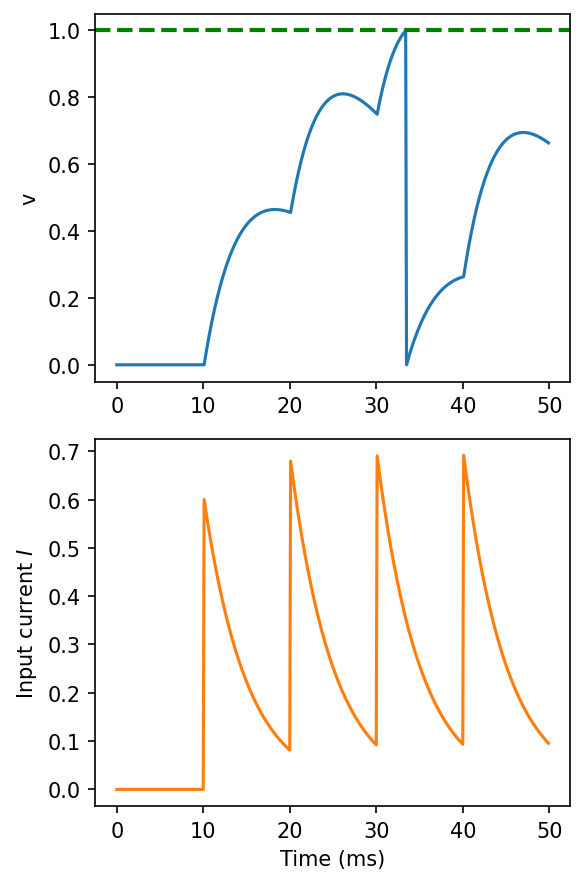

In [16]:
#| label: LIF-with-synapses-fig-label

start_scope()

duration = 50*ms

eqs = '''
dv/dt = (4*I-v)/(15*ms) : 1
dI/dt = -I/(5*ms) : 1
'''
G_out = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='euler')
nspikes_in = 100
timesep_in = 10*ms
G_in = SpikeGeneratorGroup(1, [0]*nspikes_in, (1+arange(nspikes_in))*timesep_in)
S = Synapses(G_in, G_out, on_pre='I += 0.6')
S.connect(p=1)
M = StateMonitor(G_out, ('v', 'I'), record=True)
run(duration)

figure(figsize=(4, 6), dpi=150)
subplot(211)
plot(M.t/ms, M.v[0], label='v')
axhline(1, ls='--', c='g', lw=2)
ylabel('v')
subplot(212)
plot(M.t/ms, M.I[0], label='I', c='C1')
xlabel('Time (ms)')
ylabel('Input current $I$')

tight_layout()


## Adaptive threshold LIF neuron

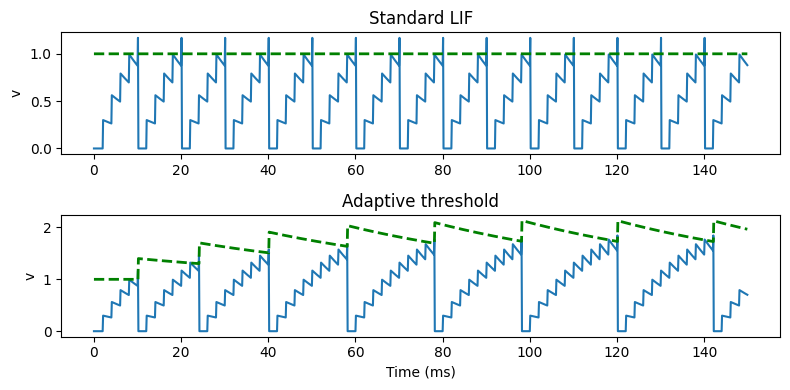

In [8]:
#| label: adaptive-LIF-fig-label

start_scope()

duration = 150*ms

eqs = '''
dv/dt = -v/(15*ms) : 1
dvt/dt = (1-vt)/(50*ms) : 1
'''
G_out = NeuronGroup(2, eqs, threshold='v>vt', reset='v=0; vt+=0.4*i', method='euler')
G_out.vt = 1
nspikes_in = 100
timesep_in = 2*ms
G_in = SpikeGeneratorGroup(1, [0]*nspikes_in, (1+arange(nspikes_in))*timesep_in)
S = Synapses(G_in, G_out, on_pre='v += 0.3')
S.connect(p=1)
M = StateMonitor(G_out, ('v', 'vt'), record=True)
run(duration)
figure(figsize=(8, 4))
subplot(211)
plot(M.t/ms, M.v[0])
plot(M.t/ms, M.vt[0], ls='--', c='g', lw=2)
ylabel('v')
title('Standard LIF')
subplot(212)
plot(M.t/ms, M.v[1])
plot(M.t/ms, M.vt[1], ls='--', c='g', lw=2)
xlabel('Time (ms)')
ylabel('v')
title('Adaptive threshold')
tight_layout()

## Hodgkin-Huxley neuron

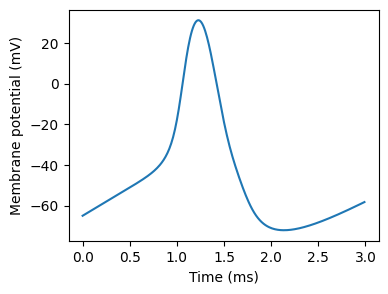

In [12]:
#| label: hodgkin-huxley-fig-label

start_scope()

duration = 3*ms

# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I = 0.7*nA * 8 : amp
''')
group = NeuronGroup(1, eqs, method='exponential_euler', dt=0.01*ms)
group.v = El

monitor = StateMonitor(group, 'v', record=True)

run(duration)

figure(figsize=(4,3))
plot(monitor.t/ms, monitor.v[0]/mV)
xlabel('Time (ms)')
_ = ylabel('Membrane potential (mV)')  # Suppress output